### Natural Language Processing Project

In this NLP project you will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. This will be a simpler procedure than the lecture, since we will utilize the pipeline methods for more complex tasks.

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix
sns.set_style('white')

#### The Data

**Read the yelp.csv file and set it as a dataframe called yelp.**

In [2]:
yelp = pd.read_csv('./dataset/yelp.csv')

**Check the head, info , and describe methods on yelp.**

In [3]:
yelp.head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0


In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


**Create a new column called "text length" which is the number of words in the text column.**

In [6]:
yelp['text length'] = yelp['text'].apply(len)

#### EDA

**Use FacetGrid from the seaborn library to create a grid of 5 histograms of text length based off of the star ratings. Reference the seaborn documentation for hints on this**

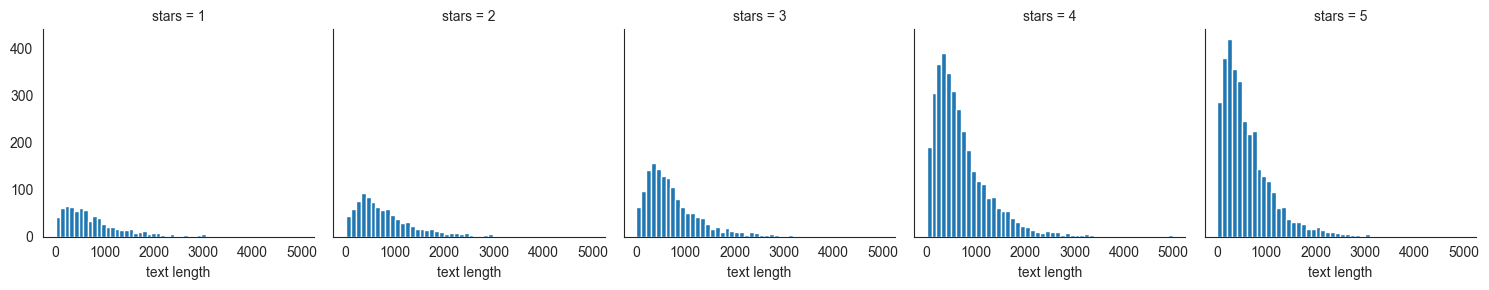

In [7]:
g = sns.FacetGrid(yelp,col='stars')
g.map(plt.hist,'text length',bins=50)

**Create a boxplot of text length for each star category.**

<Axes: xlabel='stars', ylabel='text length'>

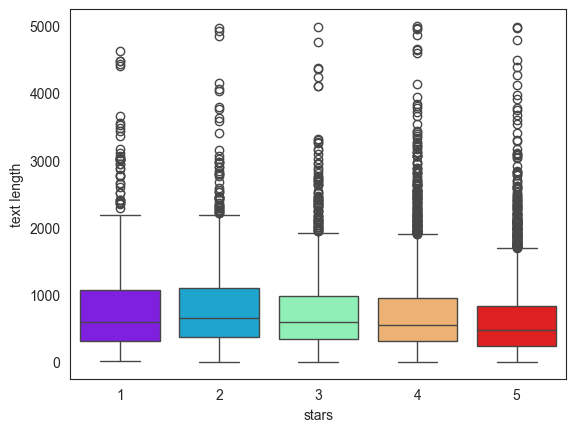

In [8]:
sns.boxplot(yelp,x='stars',y='text length',hue='stars',legend=False,palette='rainbow')

**Create a countplot of the number of occurrences for each type of star rating.**

<Axes: xlabel='stars', ylabel='count'>

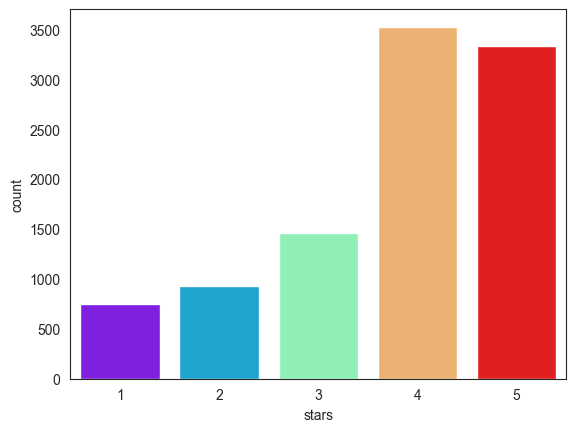

In [9]:
sns.countplot(yelp,x='stars',hue='stars',legend=False,palette='rainbow')

**Use groupby to get the mean values of the numerical columns, you should be able to create this dataframe with the operation:**

In [10]:
stars = yelp.select_dtypes(include=['number'])

In [11]:
stars = stars.groupby('stars').mean()

In [13]:
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


**Use the corr() method on that groupby dataframe to produce this dataframe:**

In [15]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


**Then use seaborn to create a heatmap based off that .corr() dataframe:**

<Axes: >

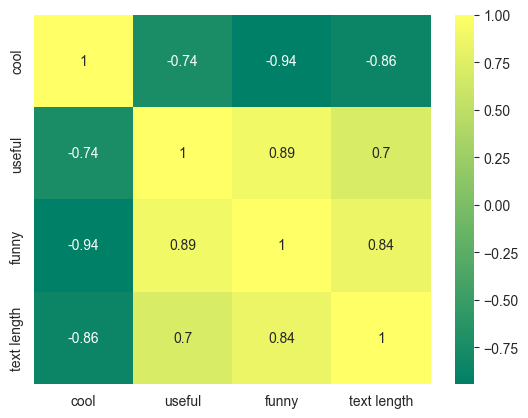

In [16]:
sns.heatmap(stars.corr(),cmap='summer',annot=True)

#### NLP Classification Task

Let's move on to the actual task. To make things a little easier, go ahead and only grab reviews that were either 1 star or 5 stars.

**Create a dataframe called yelp_class that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.**

In [18]:
yelp_class = yelp[(yelp['stars']==1) | (yelp['stars']==5)]

In [19]:
yelp_class.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4086 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  4086 non-null   object
 1   date         4086 non-null   object
 2   review_id    4086 non-null   object
 3   stars        4086 non-null   int64 
 4   text         4086 non-null   object
 5   type         4086 non-null   object
 6   user_id      4086 non-null   object
 7   cool         4086 non-null   int64 
 8   useful       4086 non-null   int64 
 9   funny        4086 non-null   int64 
 10  text length  4086 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 383.1+ KB


**Create two objects X and y. X will be the 'text' column of yelp_class and y will be the 'stars' column of yelp_class. (Your features and target/labels)**

In [20]:
X = yelp_class['text']

In [21]:
y = yelp_class['stars']

**Use the fit_transform method on the CountVectorizer object and pass in X (the 'text' column). Save this result by overwriting X.**

In [22]:
cv = CountVectorizer()

In [23]:
X = cv.fit_transform(X)

#### Train Test Split

Let's split our data into training and testing data.

**Use train_test_split to split up the data into X_train, X_test, y_train, y_test. Use test_size=0.3 and random_state=101**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#### Training a Model

Time to train a model!

**Now fit nb using the training data.**

In [26]:
nb = MultinomialNB()

In [27]:
nb.fit(X_train,y_train)

MultinomialNB()

#### Predictions and Evaluations

Time to see how our model did!

**Use the predict method off of nb to predict labels from X_test.**

In [28]:
predictions = nb.predict(X_test)

**Create a confusion matrix and classification report using these predictions and y_test**

In [32]:
print(confusion_matrix(y_test,predictions))

[[159  69]
 [ 22 976]]


In [33]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



**Great! Let's see what happens if we try to include TF-IDF to this process using a pipeline.**

#### Using Text Processing


**Now create a pipeline with the following steps:CountVectorizer(), TfidfTransformer(),MultinomialNB()**

In [35]:
pipe = Pipeline([('bow',CountVectorizer()),
                 ('tfidf',TfidfTransformer()),
                 ('model',MultinomialNB())])

#### Using the Pipeline

**Time to use the pipeline! Remember this pipeline has all your pre-process steps in it already, meaning we'll need to re-split the original data (Remember that we overwrote X as the CountVectorized version. What we need is just the text**

#### Train Test Split

**Redo the train test split on the yelp_class object.**

In [36]:
X = yelp_class['text']

In [37]:
y = yelp_class['stars']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

**Now fit the pipeline to the training data. Remember you can't use the same training data as last time because that data has already been vectorized. We need to pass in just the text and labels**

In [40]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', MultinomialNB())])

#### Predictions and Evaluation

**Now use the pipeline to predict from the X_test and create a classification report and confusion matrix. You should notice strange results.**

In [41]:
predictions = pipe.predict(X_test)

In [42]:
print(confusion_matrix(y_test,predictions))

[[  0 228]
 [  0 998]]


In [43]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



c:\Users\adepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\adepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\adepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Looks like Tf-Idf actually made things worse! 